C:\Users\ASUS\AppData\Local\Temp\ipykernel_20448\3571330923.py:39: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  nifty50_stock_returns_df = nifty50_stocks_df[stock_tickers].pct_change().dropna(how='all')


Using INR/USD exchange rate for USD correlation.


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


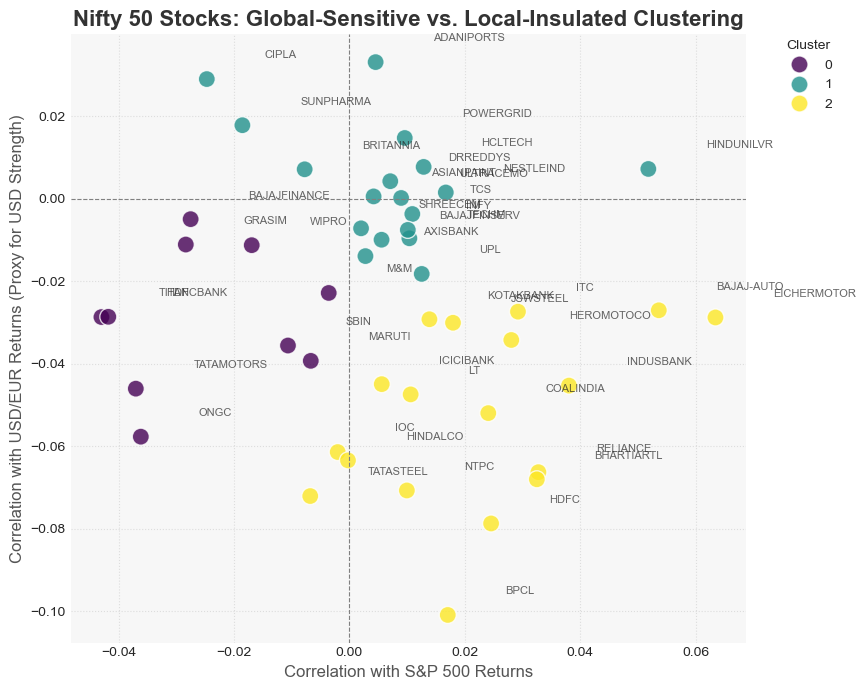

Nifty 50 Stock Clustering chart generated and saved as 'nifty50_clustering_correlations_smaller.png'


In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Datasets ---
# Ensure 'SPX.csv', 'Final-50-stocks.csv', and 'exchange_rates.csv' are in the same directory as this script.
try:
    sp500_df = pd.read_csv('SPX.csv', parse_dates=['Date'])
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
    exchange_rates_df = pd.read_csv('exchange_rates.csv', parse_dates=['date'])
except FileNotFoundError:
    print("Error: Make sure 'SPX.csv', 'Final-50-stocks.csv', and 'exchange_rates.csv' are in the same directory as this script.")
    print("Please ensure the files are correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Data Preprocessing ---

# S&P 500 Data: Select 'Date' and 'Adj Close' and calculate returns
sp500_df = sp500_df[['Date', 'Adj Close']].copy()
sp500_df.columns = ['Date', 'SP500_Close']
sp500_df = sp500_df.sort_values(by='Date').set_index('Date')
sp500_df['SP500_Returns'] = sp500_df['SP500_Close'].pct_change().dropna()

# Nifty 50 Stocks Data: Calculate individual stock returns
nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
# Remove 'Date' from stock_tickers if it somehow got included (safety check)
if 'Date' in stock_tickers:
    stock_tickers.remove('Date')

for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

# Calculate daily returns for each Nifty 50 stock, dropping rows where all stocks are NaN
nifty50_stock_returns_df = nifty50_stocks_df[stock_tickers].pct_change().dropna(how='all')

# Exchange Rates Data: Calculate USD returns (using INR/USD if possible, else USD/EUR as proxy)
usd_eur_df = exchange_rates_df[exchange_rates_df['currency'] == 'usd'][['date', 'value']].copy()
usd_eur_df.columns = ['Date', 'USD_per_EUR']
usd_eur_df = usd_eur_df.sort_values(by='Date').set_index('Date')

inr_eur_df = exchange_rates_df[exchange_rates_df['currency'] == 'inr'][['date', 'value']].copy()

usd_returns_df = pd.DataFrame() # Initialize empty DataFrame

if not inr_eur_df.empty:
    inr_eur_df.columns = ['Date', 'INR_per_EUR']
    inr_eur_df = inr_eur_df.sort_values(by='Date').set_index('Date')

    currency_merged_df = pd.merge(usd_eur_df, inr_eur_df, on='Date', how='inner')
    currency_merged_df['INR_per_USD'] = currency_merged_df['INR_per_EUR'] / currency_merged_df['USD_per_EUR']
    usd_returns_df = currency_merged_df[['INR_per_USD']].pct_change().dropna()
    usd_returns_df.columns = ['USD_Returns']
    print("Using INR/USD exchange rate for USD correlation.")
else:
    usd_returns_df = usd_eur_df[['USD_per_EUR']].pct_change().dropna()
    usd_returns_df.columns = ['USD_Returns']
    print("INR not found in exchange rates. Using USD/EUR returns as a proxy for global USD strength correlation.")


# --- Align all dataframes to a common date range for correlation calculation ---
# Common start date is limited by Nifty 50 stocks (2010-01-11)
# Common end date is limited by SPX data (2020-11-04)
common_start_date = max(nifty50_stock_returns_df.index.min(), sp500_df.index.min(), usd_returns_df.index.min())
common_end_date = min(nifty50_stock_returns_df.index.max(), sp500_df.index.max(), usd_returns_df.index.max())

nifty50_stock_returns_aligned = nifty50_stock_returns_df.loc[common_start_date:common_end_date]
sp500_returns_aligned = sp500_df['SP500_Returns'].loc[common_start_date:common_end_date]
usd_returns_aligned = usd_returns_df['USD_Returns'].loc[common_start_date:common_end_date]

# --- 3. Calculate Correlations ---
correlations = []

for stock in nifty50_stock_returns_aligned.columns:
    temp_df = pd.DataFrame({
        'Stock_Returns': nifty50_stock_returns_aligned[stock],
        'SP500_Returns': sp500_returns_aligned,
        'USD_Returns': usd_returns_aligned
    }).dropna() # Drop NaNs for this specific stock's correlation calculation

    if len(temp_df) > 30: # Ensure enough data points for meaningful correlation (e.g., > 30)
        corr_sp500 = temp_df['Stock_Returns'].corr(temp_df['SP500_Returns'])
        corr_usd = temp_df['Stock_Returns'].corr(temp_df['USD_Returns'])
        correlations.append({'Stock': stock, 'Corr_SP500': corr_sp500, 'Corr_USD': corr_usd})

correlations_df = pd.DataFrame(correlations).dropna() # Drop any rows where correlation might be NaN

# --- 4. Clustering ---
if len(correlations_df) > 0:
    X = correlations_df[['Corr_SP500', 'Corr_USD']].values

    n_clusters = 3 # Aim for 3 clusters (Global-sensitive, Local-insulated, Mixed)
    if len(X) < n_clusters: # Adjust if not enough samples
        n_clusters = len(X) if len(X) > 0 else 1

    if n_clusters > 1: # K-Means requires at least 2 clusters if n_samples > 1
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init for robustness
        correlations_df['Cluster'] = kmeans.fit_predict(X)
    elif n_clusters == 1 and len(X) > 0:
        correlations_df['Cluster'] = 0 # Assign all to one cluster if only one is possible
    else:
        print("Not enough data points to form clusters for Nifty 50 stocks.")
        exit()
else:
    print("Not enough valid correlation data for Nifty 50 stocks to perform clustering.")
    exit()

# --- 5. Visualization: Scatter Plot of Correlations with Clustering ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})

# --- CHANGE MADE HERE: Reduced figsize from (12, 9) to (10, 7) ---
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(
    data=correlations_df,
    x='Corr_SP500',
    y='Corr_USD',
    hue='Cluster', # Color points by cluster
    palette='viridis', # A visually appealing color palette
    s=150, # Size of points
    alpha=0.8,
    edgecolor='w', # White edge for points for better definition
    legend='full', # Show the full legend for clusters
    ax=ax # Ensure plotting on the created axes
)

# Add stock labels for better identification
# Adjust text positioning slightly to avoid overlap with points
for i, row in correlations_df.iterrows():
    ax.text(row['Corr_SP500'] + 0.01, row['Corr_USD'] + 0.005, row['Stock'], fontsize=8, alpha=0.7)

ax.set_title('Nifty 50 Stocks: Global-Sensitive vs. Local-Insulated Clustering', fontsize=16, fontweight='bold', color='#333333') # Reduced title font size slightly
ax.set_xlabel('Correlation with S&P 500 Returns', fontsize=12, color='#555555')
ax.set_ylabel('Correlation with USD/EUR Returns (Proxy for USD Strength)', fontsize=12, color='#555555') # Clarified Y-axis label
ax.axvline(0, color='grey', linestyle='--', linewidth=0.8) # Vertical line at 0 correlation
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Horizontal line at 0 correlation
ax.grid(True, linestyle=':', alpha=0.6) # Lighter grid
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Move legend outside plot area
plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout to make space for the legend

plt.savefig('nifty50_clustering_correlations_smaller.png') # New filename to indicate smaller size
plt.show()
plt.close(fig)

print("Nifty 50 Stock Clustering chart generated and saved as 'nifty50_clustering_correlations_smaller.png'")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26384\1297867239.py:36: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  nifty50_stock_returns_df = nifty50_stocks_df[stock_tickers].pct_change().dropna(how='all')


Using INR/USD exchange rate for USD correlation.


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26384\1297867239.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([cluster_labels.get(c, f'Cluster {c}') for c in cluster_avg_correlations['Cluster']], rotation=0)


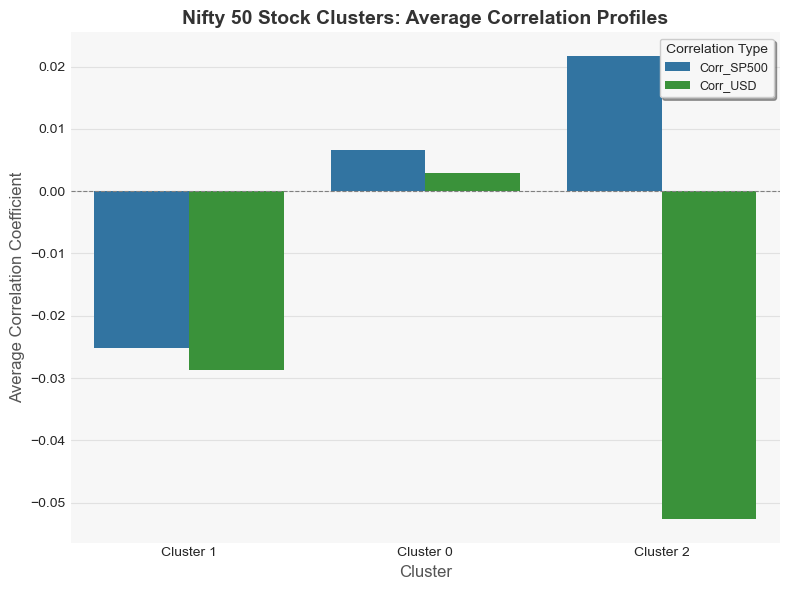

Nifty 50 Stock Clustering Average Correlation Profile Bar Chart generated and saved as 'nifty50_clustering_average_correlations_bar_chart_smaller.png'


In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Datasets ---
try:
    sp500_df = pd.read_csv('SPX.csv', parse_dates=['Date'])
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
    exchange_rates_df = pd.read_csv('exchange_rates.csv', parse_dates=['date'])
except FileNotFoundError:
    print("Error: Make sure 'SPX.csv', 'Final-50-stocks.csv', and 'exchange_rates.csv' are in the same directory as this script.")
    print("Please ensure the files are correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Data Preprocessing ---

# S&P 500 Data: Select 'Date' and 'Adj Close' and calculate returns
sp500_df = sp500_df[['Date', 'Adj Close']].copy()
sp500_df.columns = ['Date', 'SP500_Close']
sp500_df = sp500_df.sort_values(by='Date').set_index('Date')
sp500_df['SP500_Returns'] = sp500_df['SP500_Close'].pct_change().dropna()

# Nifty 50 Stocks Data: Calculate individual stock returns
nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
if 'Date' in stock_tickers:
    stock_tickers.remove('Date')

for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

nifty50_stock_returns_df = nifty50_stocks_df[stock_tickers].pct_change().dropna(how='all')

# Exchange Rates Data: Calculate USD returns (using INR/USD if possible, else USD/EUR as proxy)
usd_eur_df = exchange_rates_df[exchange_rates_df['currency'] == 'usd'][['date', 'value']].copy()
usd_eur_df.columns = ['Date', 'USD_per_EUR']
usd_eur_df = usd_eur_df.sort_values(by='Date').set_index('Date')

inr_eur_df = exchange_rates_df[exchange_rates_df['currency'] == 'inr'][['date', 'value']].copy()

usd_returns_df = pd.DataFrame()

if not inr_eur_df.empty:
    inr_eur_df.columns = ['Date', 'INR_per_EUR']
    inr_eur_df = inr_eur_df.sort_values(by='Date').set_index('Date')

    currency_merged_df = pd.merge(usd_eur_df, inr_eur_df, on='Date', how='inner')
    currency_merged_df['INR_per_USD'] = currency_merged_df['INR_per_EUR'] / currency_merged_df['USD_per_EUR']
    usd_returns_df = currency_merged_df[['INR_per_USD']].pct_change().dropna()
    usd_returns_df.columns = ['USD_Returns']
    print("Using INR/USD exchange rate for USD correlation.")
else:
    usd_returns_df = usd_eur_df[['USD_per_EUR']].pct_change().dropna()
    usd_returns_df.columns = ['USD_Returns']
    print("INR not found in exchange rates. Using USD/EUR returns as a proxy for global USD strength correlation.")


# --- Align all dataframes to a common date range ---
common_start_date = max(nifty50_stock_returns_df.index.min(), sp500_df.index.min(), usd_returns_df.index.min())
common_end_date = min(nifty50_stock_returns_df.index.max(), sp500_df.index.max(), usd_returns_df.index.max())

nifty50_stock_returns_aligned = nifty50_stock_returns_df.loc[common_start_date:common_end_date]
sp500_returns_aligned = sp500_df['SP500_Returns'].loc[common_start_date:common_end_date]
usd_returns_aligned = usd_returns_df['USD_Returns'].loc[common_start_date:common_end_date]

# --- 3. Calculate Correlations for Clustering ---
correlations = []
for stock in nifty50_stock_returns_aligned.columns:
    temp_df = pd.DataFrame({
        'Stock_Returns': nifty50_stock_returns_aligned[stock],
        'SP500_Returns': sp500_returns_aligned,
        'USD_Returns': usd_returns_aligned
    }).dropna()

    if len(temp_df) > 30: # Ensure enough data points for meaningful correlation
        corr_sp500 = temp_df['Stock_Returns'].corr(temp_df['SP500_Returns'])
        corr_usd = temp_df['Stock_Returns'].corr(temp_df['USD_Returns'])
        correlations.append({'Stock': stock, 'Corr_SP500': corr_sp500, 'Corr_USD': corr_usd})

correlations_df = pd.DataFrame(correlations).dropna()

# --- 4. Clustering ---
if len(correlations_df) > 0:
    X = correlations_df[['Corr_SP500', 'Corr_USD']].values
    n_clusters = 3 # Aim for 3 clusters (Global-sensitive, Local-insulated, Mixed)
    if len(X) < n_clusters:
        n_clusters = len(X) if len(X) > 0 else 1

    if n_clusters > 1:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        correlations_df['Cluster'] = kmeans.fit_predict(X)
    elif n_clusters == 1 and len(X) > 0:
        correlations_df['Cluster'] = 0
    else:
        print("Not enough data points to form clusters for Nifty 50 stocks.")
        exit()
else:
    print("Not enough valid correlation data for Nifty 50 stocks to perform clustering.")
    exit()

# --- 5. Visualization: Average Correlation Profile of Each Cluster (Grouped Bar Chart) ---

# Calculate the mean correlation for each cluster
cluster_avg_correlations = correlations_df.groupby('Cluster')[['Corr_SP500', 'Corr_USD']].mean().reset_index()

# Melt the DataFrame for easier plotting with seaborn's barplot
cluster_avg_correlations_melted = cluster_avg_correlations.melt(
    id_vars='Cluster',
    var_name='Correlation Type',
    value_name='Average Correlation'
)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})

# --- CHANGE MADE HERE: Reduced figsize from (10, 7) to (8, 6) ---
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=cluster_avg_correlations_melted,
    x='Cluster',
    y='Average Correlation',
    hue='Correlation Type',
    palette={'Corr_SP500': '#1f77b4', 'Corr_USD': '#2ca02c'}, # Blue for SP500, Green for USD
    ax=ax
)

ax.set_title('Nifty 50 Stock Clusters: Average Correlation Profiles', fontsize=14, fontweight='bold', color='#333333') # Adjusted title font size
ax.set_xlabel('Cluster', fontsize=12, color='#555555')
ax.set_ylabel('Average Correlation Coefficient', fontsize=12, color='#555555')
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Horizontal line at 0 correlation for reference

# Customize x-axis tick labels for clusters
cluster_labels = {
    0: 'Cluster 1',
    1: 'Cluster 0',
    2: 'Cluster 2'
}
ax.set_xticklabels([cluster_labels.get(c, f'Cluster {c}') for c in cluster_avg_correlations['Cluster']], rotation=0)

ax.legend(title='Correlation Type', loc='upper right', fontsize=9, frameon=True, fancybox=True, shadow=True) # Adjusted legend font size

plt.tight_layout()
plt.savefig('nifty50_clustering_average_correlations_bar_chart_smaller.png') # New filename
plt.show()
plt.close(fig)

print("Nifty 50 Stock Clustering Average Correlation Profile Bar Chart generated and saved as 'nifty50_clustering_average_correlations_bar_chart_smaller.png'")
